In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from src.preprocessing import display_missing_values
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_theme(style="ticks", palette="pastel")

from sklearn.preprocessing import PolynomialFeatures, RobustScaler, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, BaggingRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
from new_preprocessing import Dataset, group_fuel_types


In [3]:
train=Dataset("data/train.csv")
data_train=train.load_data()
test=Dataset("data/test.csv")
data_test=test.load_data()

In [4]:
from new_preprocessing import Preprocessor
train_preprocessor=Preprocessor(data_train)
test_preprocessor=Preprocessor(data_test)

In [5]:
variables_continues=["Fuel consumption ","Electric range (km)","ec (cm3)","z (Wh/km)","W (mm)"]

In [6]:
train_preprocessor.fill_fuel_consumption()
train_preprocessor.fill_electric_range()
train_preprocessor.fill_engine_capacity()
train_preprocessor.fill_electric_consumption()
train_preprocessor.fill_category_type()
train_preprocessor.fill_wheel_base()
train_preprocessor.fill_At_1()
train_preprocessor.fill_At_2()
train_preprocessor.fill_mass()
train_preprocessor.fill_engine_power()
train_preprocessor.fill_vehicule_family_number()
train_preprocessor.encode_country()
train_preprocessor.encode_manufacture_pooling()
train_preprocessor.encode_manufacturer_name()
train_preprocessor.encode_fuel_mode()
train_preprocessor.encode_fuel_type()
train_preprocessor.encode_category_registered()
train_preprocessor.encode_category_type()
train_preprocessor.encode_vehicule_family_number()
train_preprocessor.last_step()

test_preprocessor.fill_fuel_consumption()
test_preprocessor.fill_electric_range()
test_preprocessor.fill_engine_capacity()
test_preprocessor.fill_electric_consumption()
test_preprocessor.fill_category_type()
test_preprocessor.fill_wheel_base()
test_preprocessor.fill_At_1()
test_preprocessor.fill_At_2()
test_preprocessor.fill_mass()
test_preprocessor.fill_engine_power()
test_preprocessor.fill_vehicule_family_number()
test_preprocessor.encode_country()
test_preprocessor.encode_manufacture_pooling()
test_preprocessor.encode_manufacturer_name()
test_preprocessor.encode_fuel_mode()
test_preprocessor.encode_fuel_type()
test_preprocessor.encode_category_registered()
test_preprocessor.encode_category_type()
test_preprocessor.encode_vehicule_family_number()
test_preprocessor.last_step()

In [7]:
quantiles={}

def winsorize_outliers(data, column_name, lower_percentile=5, upper_percentile=95,train=True):
    """
    Detects and imputes outliers using winsorizing for a specific column in a DataFrame.

    Parameters:
    - data: Pandas DataFrame, input data
    - column_name: str, name of the column to be winsorized
    - lower_percentile: int, lower percentile for winsorizing (default: 5)
    - upper_percentile: int, upper percentile for winsorizing (default: 95)

    Returns:
    - winsorized_data: Pandas DataFrame, data with outliers winsorized for the specified column
    """

    column_data = data[column_name]
    if train:
        quantiles["q1"] = np.percentile(column_data, lower_percentile)
        quantiles["q3"] = np.percentile(column_data, upper_percentile)
        iqr = quantiles["q3"] - quantiles["q1"]
        quantiles["lower_bound"] = quantiles["q1"] - 1.5 * iqr
        quantiles["upper_bound"] = quantiles["q3"] + 1.5 * iqr

    data[column_name] = np.clip(column_data, quantiles["lower_bound"], quantiles["upper_bound"])

    return data

for col in variables_continues:
    data_train=winsorize_outliers(data_train,col)
    data_test =winsorize_outliers(data_test,col,train=False)

In [8]:
others=[col for col in data_train.columns if col not in variables_continues]

In [9]:
poly = PolynomialFeatures(degree=2,include_bias=False)

# Application de la transformation aux variables continues
variables_continues_transformees = poly.fit_transform(data_train[variables_continues])

data_train_transforme = pd.DataFrame(variables_continues_transformees, columns=poly.get_feature_names_out(variables_continues))
data_train= pd.concat([data_train[others],data_train_transforme], axis=1)



In [10]:
variables_continues_transformees = poly.fit_transform(data_test[variables_continues])

data_test_transforme = pd.DataFrame(variables_continues_transformees, columns=poly.get_feature_names_out(variables_continues))
data_test= pd.concat([data_test[list(filter(lambda x: x !='Ewltp (g/km)',others))],data_train_transforme], axis=1)

In [11]:
# def create_conforme(df):
#     # df['conforme'] = df['Tan'].isna()
#     df['conforme'] = df['Tan'].apply(lambda x: 1 if x else 0)
#     df.drop(columns='Tan', inplace=True)
#     pass

# def compute_surface(obs):
#     max_largeur= max(obs['At1 (mm)'], obs['At2 (mm)'])
#     return obs['W (mm)']*obs['At1 (mm)'] if max_largeur == obs['At1 (mm)'] else obs['W (mm)'] * obs['At2 (mm)']

# compute_surface_bis=lambda obs: obs['W (mm)']*(obs['At1 (mm)']+ obs['At2 (mm)'])/2

# def create_surface(df):
#     df['surface']= df.apply(compute_surface_bis, axis=1)
#     pass

In [12]:
def create_conforme(df):
    df['conforme'] = df['Tan'].notna().astype(int)
    df.drop(columns=['Tan'], inplace=True)

def compute_surface(obs):
    max_largeur = np.max(obs['At1 (mm)'], obs['At2 (mm)'])
    return obs['W (mm)'] * obs['At1 (mm)'] if max_largeur == obs['At1 (mm)'] else obs['W (mm)'] * obs['At2 (mm)']

def create_surface(df):
    df['surface'] = df['W (mm)'] * (df['At1 (mm)'] + df['At2 (mm)']) / 2


In [13]:
create_conforme(data_train)
create_surface(data_train)

create_conforme(data_test)
create_surface(data_test)

In [14]:
new_cat=['Mh', 'T', 'Mk', 'Cn','Mt','Fm']
le=LabelEncoder()
cat=SimpleImputer(strategy='most_frequent')
data_train[new_cat]=cat.fit_transform(data_train[new_cat])
data_test[new_cat]=cat.fit_transform(data_test[new_cat])
for col in new_cat:
    data_train[col]=le.fit_transform(data_train[col])
    data_test[col]=le.fit_transform(data_test[col])

In [15]:
new_cat = ['Mh', 'T', 'Mk', 'Cn', 'Mt', 'Fm']
le = LabelEncoder()
cat_imputer = SimpleImputer(strategy='most_frequent')

# Imputer les valeurs manquantes et appliquer la transformation LabelEncoder en même temps
for col in new_cat:
    data_train[col] = le.fit_transform(cat_imputer.fit_transform(data_train[[col]]))
    data_test[col] = le.fit_transform(cat_imputer.fit_transform(data_test[[col]]))

c:\Users\jeann\Desktop\M2\New Data Mining Challenge\Projet_Mining\.venv_mining\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeann\Desktop\M2\New Data Mining Challenge\Projet_Mining\.venv_mining\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeann\Desktop\M2\New Data Mining Challenge\Projet_Mining\.venv_mining\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jeann\Desktop\M2\New D

In [16]:
drop_this=['Erwltp (g/km)'] #'VFN','W (mm)', 'At1 (mm)', 'At2 (mm)',,'Man','Mh', 'T', 'Mk', 'Cn','Mt','Fm',

data_train.drop(columns=drop_this, inplace=True)
data_test.drop(columns=drop_this, inplace=True)

In [17]:
data_train.drop(columns='ID',inplace=True)

In [18]:
list_vars=["Ewltp (g/km)", "m (kg)","ec (cm3)", "ep (KW)", "z (Wh/km)", "Fuel consumption ","Electric range (km)", "surface",'W (mm)', 'At1 (mm)', 'At2 (mm)']

<function matplotlib.pyplot.show(close=None, block=None)>

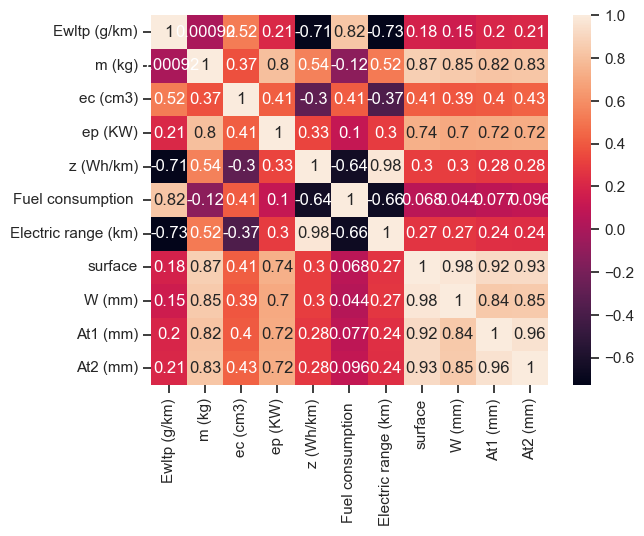

<Figure size 2000x2000 with 0 Axes>

In [19]:
sns.heatmap(data_train[list_vars].corr(method='spearman'),annot=True)
plt.figure(figsize=(20,20))
plt.show

In [20]:
from sklearn.linear_model import LassoCV, ElasticNetCV

In [21]:
train, test = train_test_split(data_train, test_size=0.33, random_state=0,)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

X_train, y_train = train.drop(columns=["Ewltp (g/km)"]).to_numpy(), train["Ewltp (g/km)"].to_numpy()
X_test, y_test = test.drop(columns=["Ewltp (g/km)"]).to_numpy(), test["Ewltp (g/km)"].to_numpy()

In [2]:
import pandas as pd

def display_missing_values(df:pd.DataFrame)->pd.DataFrame:
    """
    Afficher dans un dataframe par ordre décroissant les colonnes,
    le pourcentage et le nombre de valeurs manquantes qu'elles possèdent

    Parameters:
    -----------
    pd.DataFrame

    Returns:
    --------
    pd.DataFrame
        Data frame avec les NaN correctement trouvés
    """
    dico_nan = []

    for col in df.columns:
        dico_nan = dico_nan + [{"Colonne" : col,"pourcentage manquant" : df[col].isna().sum()/len(df)*100 ,"nombre" : df[col].isna().sum()}] 
    dico_nan.sort(key = lambda x: x.get('pourcentage manquant'),reverse = True)

    return pd.DataFrame(dico_nan)

"""
26 Décembre: Préprocessing
"""
# 0.1- Imports (ya des trucs inutiles au preprocessing)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor,BaggingRegressor,AdaBoostRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, RobustScaler, PolynomialFeatures, TargetEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from category_encoders import LeaveOneOutEncoder
from category_encoders.count import CountEncoder
from category_encoders.cat_boost import CatBoostEncoder
import joblib

from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
import xgboost as xgb
from xgboost.callback import EarlyStopping, LearningRateScheduler

#from pytorch_tabnet.tab_model import TabNetRegressor

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
sns.set_theme(style="ticks", palette="pastel")


# 0.2 - Charger la donnée

data_train= pd.read_csv("data/train.csv",sep=",",low_memory=False)
data_test = pd.read_csv("data/test.csv",sep=",",low_memory=False)

data_train.name="data_train"
data_test.name="data_test"

# 1- Récupération d'observations

def group_fuel_types(category: str):
    if category in ['PETROL/ELECTRIC', 'DIESEL/ELECTRIC']:
        return "HYBRID"
    elif category in ['NG-BIOMETHANE', 'HYDROGEN', 'NG','E85']:
        return "BIO-FUEL"
    elif category in ['PETROL','LPG'] :
        return 'PETROL'
    else:
        return category   

def recup_electric(df):
    #  ec (cm3)
    df.loc[(df["Ft"].apply(group_fuel_types)=="ELECTRIC") & (df["ec (cm3)"].isna()),"ec (cm3)"] = 0
    #  Fm
    df.loc[(df["Ft"].apply(group_fuel_types) =="ELECTRIC") & (df["Fm"].isna()),"Fm"] = "E"
    df.loc[(df["Ft"].apply(group_fuel_types) =="HYBRID") & (df["Fm"].isna()),"Fm"] = "P"

    # Electric range (km)
    df.loc[~(df["Ft"].apply(group_fuel_types).isin(["ELECTRIC", "HYBRID"])) & (df["Electric range (km)"].isna()),"Electric range (km)"] = 0

    #  Fuel consumption 
    df.loc[(df["Ft"].apply(group_fuel_types) =="ELECTRIC") & (df["Fuel consumption "].isna()),"Fuel consumption "] = 0

    #  z (Wh/km)
    df.loc[~(df["Ft"].apply(group_fuel_types).isin(["ELECTRIC", "HYBRID"])) & (df["z (Wh/km)"].isna()),"z (Wh/km)"] = 0
    pass

recup_electric(data_train)
recup_electric(data_test)

# 2- Delete useless columns 

valeurs_uniques = {}
nombre_val_unique={}
for col in data_train.columns:
    valeurs_uniques[col]=data_train[col].unique().tolist()
    nombre_val_unique[col]=data_train[col].nunique()

for element in nombre_val_unique:
    if nombre_val_unique[element]<=1:
        print(f"colonne supprimée: {element}")
        data_train.drop(columns=element, inplace=True)
        data_test.drop(columns=element, inplace=True)

for col in data_train.columns:
    if (data_train[col].isna().sum()/data_train.shape[0] > 0.5):
        print(f"colonne supprimée: {col}")
        data_train.drop(columns=col, inplace=True)
        data_test.drop(columns=col, inplace=True)

data_train.drop(columns=['Date of registration','ID'], inplace=True)
data_test.drop(columns='Date of registration', inplace=True)

print(f"colonne supprimée pour data_train: Date of registration, ID")
print(f"colonne supprimée pour data_test: Date of registration")

col_categoricals = data_test.select_dtypes(include="object").columns.tolist()
col_numericals = [col for col in data_test.columns if col not in col_categoricals]
col_numericals.remove("ID")

# 3- Traitement des Outliers par Winsorization (on cap la donnée au 5e et 95e quantile)

quantiles={}

def winsorize_outliers(data, column_name, lower_percentile=5, upper_percentile=95,train=True):
    """
    Detects and imputes outliers using winsorizing for a specific column in a DataFrame.

    Parameters:
    - data: Pandas DataFrame, input data
    - column_name: str, name of the column to be winsorized
    - lower_percentile: int, lower percentile for winsorizing (default: 5)
    - upper_percentile: int, upper percentile for winsorizing (default: 95)

    Returns:
    - winsorized_data: Pandas DataFrame, data with outliers winsorized for the specified column
    """

    column_data = data[column_name]
    if train:
        quantiles["q1"] = np.percentile(column_data, lower_percentile)
        quantiles["q3"] = np.percentile(column_data, upper_percentile)
        iqr = quantiles["q3"] - quantiles["q1"]
        quantiles["lower_bound"] = quantiles["q1"] - 1.5 * iqr
        quantiles["upper_bound"] = quantiles["q3"] + 1.5 * iqr

    data[column_name] = np.clip(column_data, quantiles["lower_bound"], quantiles["upper_bound"])

    return data

for col in col_numericals:
    data_train=winsorize_outliers(data_train,col)
    data_test =winsorize_outliers(data_test,col,train=False)

# 4- NaN imputation

imputers={}
_coefficient_variation= lambda series : series.std()/series.mean()

def fill_missing_values(colname : str,data:pd.DataFrame) -> None:
    
    if data[colname].dtype in ["float64"]:
        if _coefficient_variation(data[colname]) > 0.15 :
            imputers[colname]=SimpleImputer(missing_values=np.nan,strategy="median")
        else:
            imputers[colname]=SimpleImputer(missing_values=np.nan,strategy="mean")
    else:
        imputers[colname]=SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    imputers[colname].fit(data[colname].to_numpy().reshape(-1,1))
    pass

for col in data_test.columns[1:]:
    fill_missing_values(col,data_train)
    data_train[col]=pd.Series(imputers[col].transform(data_train[col].to_numpy().reshape(-1,1)).flatten())
    data_test[col]=pd.Series(imputers[col].transform(data_test[col].to_numpy().reshape(-1,1)).flatten())

# 5- Custom Encoding 
"""
Mélange de Count Encoder (nunique >=15) et OHE (else).

Il y a les catboost et ordinal encoder avec si tu veux mais la combinaison que j'ai trouvé et plus efficace
""" 

encoders = {}

def cat_boost_encoder(col,df,train=True):
    if train:
        encoders[col]= CatBoostEncoder(random_state=42)
        df[col]=encoders[col].fit_transform(df[[col]],df[['Ewltp (g/km)']])
    else:
        df[col]=encoders[col].transform(df[[col]])
    pass

def ohe_encoder(col,df,train=True):
    if train:
        encoders[col] = OneHotEncoder(sparse_output=False, drop='first',handle_unknown='ignore') #sparse = false sinn jsais pas gérer
        ohe_features = encoders[col].fit_transform(df[[col]])
    else: 
        ohe_features = encoders[col].transform(df[[col]])

    ohe_features = pd.DataFrame(ohe_features, columns=encoders[col].get_feature_names_out([col]))

    df.drop(columns=col, inplace=True)
    df.reset_index(drop=True, inplace=True)
    df = pd.concat([df, ohe_features], axis=1)
    return df

def count_encoder(col, df, train=True):
    if train:
        encoders[col]=CountEncoder(handle_unknown='value')
        df[col]=encoders[col].fit_transform(df[[col]])
    else:
        df[col]=encoders[col].transform(df[[col]])
    pass

def ordinal_encoder(colname:str,data:pd.DataFrame,train=True):
    if train:
        encoders[colname]=OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        data[colname]=encoders[colname].fit_transform(data[[colname]])
    else:
        data[colname]=encoders[colname].transform(data[[colname]])
    pass

for col in col_categoricals:
    if nombre_val_unique[col]>=15: #eventually replace by catboost encoder but careful cuz of Target ! (do TTS first)
        count_encoder(col,data_train)
        count_encoder(col,data_test,False)
        print(f"encoding count : {col}")
    else:
        data_train=ohe_encoder(col,data_train) #reassign cuz you don't know how to do it...
        data_test=ohe_encoder(col,data_test, False)
        print(f"encoding OHE : {col}")

# 6- Split
        
train, test = train_test_split(data_train, test_size=0.33, random_state=42)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

X_train, y_train = train.drop(columns=["Ewltp (g/km)"]), train["Ewltp (g/km)"]
X_test, y_test = test.drop(columns=["Ewltp (g/km)"]), test["Ewltp (g/km)"]

colonne supprimée: MMS
colonne supprimée: r
colonne supprimée: Ernedc (g/km)
colonne supprimée: De
colonne supprimée: Vf
colonne supprimée: Status
colonne supprimée: Enedc (g/km)
colonne supprimée pour data_train: Date of registration, ID
colonne supprimée pour data_test: Date of registration
encoding count : Country
encoding count : VFN
encoding OHE : Mp
encoding count : Mh
encoding count : Man
encoding count : Tan
encoding count : T
encoding count : Va
encoding count : Ve
encoding count : Mk
encoding count : Cn
encoding OHE : Ct
encoding OHE : Cr
encoding OHE : Ft
encoding OHE : Fm
encoding count : IT


In [3]:
liste1 = [4]
liste2 = [4, 5, 6]

liste1.extend(liste2)

print(liste1)  # Output: [1, 2, 3, 4, 5, 6]


[4, 4, 5, 6]


In [22]:
train

,Country,VFN,Mp,Mh,Man,T,Mk,Cn,Ct,Cr,m (kg),Mt,Ewltp (g/km),At1 (mm),At2 (mm),Ft,Fm,ep (KW),Fuel consumption,Electric range (km),ec (cm3),z (Wh/km),W (mm),Fuel consumption ^2,Fuel consumption Electric range (km),Fuel consumption ec (cm3),Fuel consumption z (Wh/km),Fuel consumption W (mm),Electric range (km)^2,Electric range (km) ec (cm3),Electric range (km) z (Wh/km),Electric range (km) W (mm),ec (cm3)^2,ec (cm3) z (Wh/km),ec (cm3) W (mm),z (Wh/km)^2,z (Wh/km) W (mm),W (mm)^2,conforme,surface
0,23,1764,2,41,41,380,222,1494,0.00,0.00,1145.00,218,389.36,1555.00,1555.00,4.00,4,62.00,4.80,0.00,1197.00,0.00,2580.00,23.04,0.00,5745.60,0.00,12384.00,0.00,0.00,0.00,0.00,1432809.00,0.00,3088260.00,0.00,0.00,6656400.00,1,4011900.00
1,5,627,0,13,14,628,76,7911,0.00,0.00,1615.00,733,428.64,1562.00,1563.00,1.00,4,110.00,5.20,0.00,1995.00,0.00,2670.00,27.04,0.00,10374.00,0.00,13884.00,0.00,0.00,0.00,0.00,3980025.00,0.00,5326650.00,0.00,0.00,7128900.00,1,4171875.00
2,10,5494,6,76,85,1156,113,2858,0.00,0.00,1338.00,460,442.74,1563.00,1570.00,4.00,4,110.00,6.20,0.00,1332.00,0.00,2673.00,38.44,0.00,8258.40,0.00,16572.60,0.00,0.00,0.00,0.00,1774224.00,0.00,3560436.00,0.00,0.00,7144929.00,1,4187254.50
3,5,6402,10,83,92,989,564,4482,1.00,1.00,1795.00,999,546.71,1565.00,1575.00,1.00,4,147.00,6.60,0.00,1968.00,0.00,2788.00,43.56,0.00,12988.80,0.00,18400.80,0.00,0.00,0.00,0.00,3873024.00,0.00,5486784.00,0.00,0.00,7772944.00,1,4377160.00
4,8,4234,6,76,85,1078,518,5219,0.00,0.00,1588.00,694,1.00,1555.00,1545.00,2.00,1,55.00,0.00,294.00,0.00,159.00,2685.00,0.00,0.00,0.00,0.00,0.00,86436.00,0.00,46746.00,789390.00,0.00,0.00,0.00,25281.00,426915.00,7209225.00,1,4161750.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5072999,4,7231,10,83,92,186,564,3304,0.00,0.00,1136.00,281,389.87,1553.38,1555.46,4.00,4,70.00,5.40,0.00,999.00,0.00,2455.00,29.16,0.00,5394.60,0.00,13257.00,0.00,0.00,0.00,0.00,998001.00,0.00,2452545.00,0.00,0.00,6027025.00,1,3816097.76
5073000,24,8031,7,75,83,1240,485,2326,0.00,0.00,1530.00,639,-3.39,1500.00,1500.00,2.00,1,100.00,0.00,351.00,0.00,159.00,2540.00,0.00,0.00,0.00,0.00,0.00,123201.00,0.00,55809.00,891540.00,0.00,0.00,0.00,25281.00,403860.00,6451600.00,1,3810000.00
5073001,4,6684,10,83,92,991,564,4444,0.00,0.00,1417.00,566,457.15,1553.38,1555.46,4.00,4,110.00,6.40,0.00,1498.00,0.00,2625.00,40.96,0.00,9587.20,0.00,16800.00,0.00,0.00,0.00,0.00,2244004.00,0.00,3932250.00,0.00,0.00,6890625.00,1,4080348.93
5073002,8,8414,7,70,80,1011,485,2453,0.00,0.00,1254.00,428,422.48,1513.00,1491.00,4.00,4,81.00,5.40,0.00,1199.00,0.00,2604.00,29.16,0.00,6474.60,0.00,14061.60,0.00,0.00,0.00,0.00,1437601.00,0.00,3122196.00,0.00,0.00,6780816.00,1,3911208.00


In [ ]:
lasso = LassoCV(cv=5,)
lasso.fit(X_train, y_train)

# Affichez les coefficients sélectionnés
selected_features = X_train.columns[lasso.coef_ != 0]
print("Variables sélectionnées par Adaptive LASSO :")
print(selected_features)

In [3]:
import xgboost as xgb

In [4]:
import numba
from numba import cuda

In [5]:
@numba.jit
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

C:\Users\jeann\AppData\Local\Temp\ipykernel_25480\13295361.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def evaluate_model(model, X_test, y_test):


In [6]:
@numba.jit
def train_xgboost(X:np.array,y:np.array,n_estimators=2000 ,objective='reg:squarederror',max_depth=10, learning_rate=0.2):
    xgboost_model=xgb.XGBRegressor(n_estimators=n_estimators ,objective=objective, 
                                   max_depth=max_depth,learning_rate=learning_rate, n_jobs=-1,device="cuda",subsample=0.9,)
                                    #tree_method="gpu_hist", eval_metric="mae",reg_alpha=0.1,reg_lambda=0.1,booster="gblinear")
    xgboost_model.fit(X, y)
    return xgboost_model

C:\Users\jeann\AppData\Local\Temp\ipykernel_25480\2358840053.py:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def train_xgboost(X:np.array,y:np.array,n_estimators=2000 ,objective='reg:squarederror',max_depth=10, learning_rate=0.2):


In [13]:
xgboost_model=train_xgboost(X_train,y_train,max_depth=14)

c:\Users\jeann\Desktop\M2\New Data Mining Challenge\Projet_Mining\.venv_mining\lib\site-packages\xgboost\core.py:160: UserWarning: [18:16:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


In [14]:
mae=evaluate_model(xgboost_model,X_test,y_test)

In [15]:
mae

2.9075673223516887

In [39]:
xgboost_models=[]
for depth in [10, 12, 15, 16, 18]: #, 6, 8,
    xgboost_model=train_xgboost(X_train,y_train,max_depth=depth)
    xgboost_models.append(xgboost_model)
    print(evaluate_model(xgboost_model,X_test,y_test))

c:\Users\jeann\Desktop\M2\New Data Mining Challenge\Projet_Mining\.venv_mining\lib\site-packages\xgboost\core.py:160: UserWarning: [23:02:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


3.0406749317575357


c:\Users\jeann\Desktop\M2\New Data Mining Challenge\Projet_Mining\.venv_mining\lib\site-packages\xgboost\core.py:160: UserWarning: [23:18:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


2.9750880092879988


c:\Users\jeann\Desktop\M2\New Data Mining Challenge\Projet_Mining\.venv_mining\lib\site-packages\xgboost\core.py:160: UserWarning: [23:35:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


2.940624786876653


c:\Users\jeann\Desktop\M2\New Data Mining Challenge\Projet_Mining\.venv_mining\lib\site-packages\xgboost\core.py:160: UserWarning: [23:58:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


2.9374671600284668


c:\Users\jeann\Desktop\M2\New Data Mining Challenge\Projet_Mining\.venv_mining\lib\site-packages\xgboost\core.py:160: UserWarning: [00:23:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


2.9396716829655167


In [ ]:
# mae_final

In [30]:
new_features=[]
for i,model in enumerate(xgboost_models):
    new_features.append(model.predict(X_train))
new_features=np.array(new_features).T

In [31]:
from sklearn.linear_model import LinearRegression
linear_regression=LinearRegression()

In [32]:
linear_regression.fit(new_features,y_train)

LinearRegression()

In [35]:
weights=linear_regression.coef_

In [ ]:
predicitions=[]
for i,model in enumerate(xgboost_models):
    predicitions.append(model.predict(X_test))
predicitions=np.array(predicitions).T

In [37]:
final_predictions=np.dot(predicitions.T,weights)
mae_final=mean_absolute_error(y_test,final_predictions)

In [38]:
mae_final

2.95299462159781

In [ ]:
# 2.933273231151733 

In [ ]:
evaluate_model(xgboost_model,X_train,y_train)

In [ ]:
mae

In [ ]:
from lightgbm import LGBMRegressor
lgbm=LGBMRegressor(verbose=0)

In [ ]:
lgbm.fit(X_train,y_train)

In [ ]:
mae_lgbm=evaluate_model(lgbm,X_test,y_test)

In [ ]:
mae_lgbm

In [ ]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import numpy as np

# Supposons que X_train, y_train, X_test soient vos ensembles d'entraînement et de test

# Définir les hyperparamètres de XGBoost
params = {
    'objective': 'reg:squarederror',  # Regression objective
    'eval_metric': 'mae',  # Mean Absolute Error as evaluation metric
    'learning_rate': 0.2,
    'max_depth': 12,
    'n_estimators': 2000,
    'n_jobs':-1#,    'device':"cuda"
}
models=[]
# Nombre de folds pour la validation croisée
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialiser une liste pour stocker les prédictions sur le jeu de test de chaque fold
test_predictions = []

# Effectuer la validation croisée
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Créer et entraîner le modèle XGBoost
    model = xgb.XGBRegressor(**params)
    model.fit(X_train_fold, y_train_fold)
    models.append(model)
    # Faire des prédictions sur le jeu de validation
    val_preds = model.predict(X_val_fold)

    # Calculer la MAE pour le fold actuel
    fold_mae = mean_absolute_error(y_val_fold, val_preds)
    print(f'MAE for this fold: {fold_mae}')

    # Faire des prédictions sur le jeu de test
    test_fold_preds = model.predict(X_test)
    test_predictions.append(test_fold_preds)

# Calculer la moyenne pondérée des prédictions sur le jeu de test
final_test_predictions = np.mean(np.array(test_predictions), axis=0)

# Évaluer la MAE sur le jeu de test complet
final_mae = mean_absolute_error(y_test, final_test_predictions)
print(f'\nFinal MAE on test set: {final_mae}')

In [17]:
X_train=X_train.to_numpy()
X_test=X_test.to_numpy()
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()


In [18]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np

# Supposons que X_train, y_train, X_test soient vos ensembles d'entraînement et de test

# Définir les hyperparamètres de XGBoost
params = {
    'estimator':DecisionTreeRegressor(max_depth=10),
    'n_jobs':10,
    'bootstrap':True,
    'oob_score':True,
    'random_state':42,
    'verbose':100,
    'max_features':0.9,
    'max_samples':0.9,
    'n_estimators':200
}
models=[]
# Nombre de folds pour la validation croisée
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialiser une liste pour stocker les prédictions sur le jeu de test de chaque fold
test_predictions = []

# Effectuer la validation croisée
for train_index, val_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Créer et entraîner le modèle XGBoost
    model = BaggingRegressor(**params)
    model.fit(X_train_fold, y_train_fold)
    models.append(model)
    # Faire des prédictions sur le jeu de validation
    val_preds = model.predict(X_val_fold)

    # Calculer la MAE pour le fold actuel
    fold_mae = mean_absolute_error(y_val_fold, val_preds)
    print(f'MAE for this fold: {fold_mae}')

    # Faire des prédictions sur le jeu de test
    test_fold_preds = model.predict(X_test)
    test_predictions.append(test_fold_preds)

# Calculer la moyenne pondérée des prédictions sur le jeu de test
final_test_predictions = np.mean(np.array(test_predictions), axis=0)

# Évaluer la MAE sur le jeu de test complet
final_mae = mean_absolute_error(y_test, final_test_predictions)
print(f'\nFinal MAE on test set: {final_mae}')

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


MemoryError: Unable to allocate 1.39 GiB for an array with shape (46, 4058403) and data type float64